In [17]:
import os
import shutil
import random; random.seed(42)

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.optim as optim

import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.experimental import stax
from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

In [2]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

In [3]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [4]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

In [5]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [6]:
# choose an initial state
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [7]:
x_analytical = jax.device_get(solve_analytical(x0, t))

In [8]:
time_step = 0.01
N = 1500
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.arange(N, dtype=np.float32) # time steps 0 to N
%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step

noise = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
%time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
%time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
%time y_test = jax.device_get(analytical_step(x_test)) # analytical next step


CPU times: user 9.84 s, sys: 0 ns, total: 9.84 s
Wall time: 9.82 s
CPU times: user 676 ms, sys: 219 ms, total: 895 ms
Wall time: 1.8 s
CPU times: user 871 ms, sys: 0 ns, total: 871 ms
Wall time: 1.36 s
CPU times: user 10.2 s, sys: 219 µs, total: 10.2 s
Wall time: 10.2 s
CPU times: user 42.4 ms, sys: 142 µs, total: 42.5 ms
Wall time: 38.8 ms
CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 1.44 ms


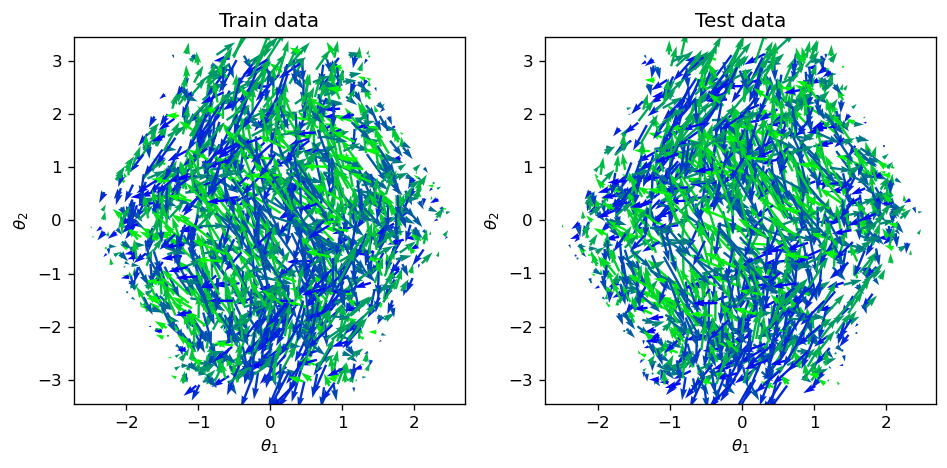

In [9]:
# preprocess
train_vis = jax.vmap(normalize_dp)(x_train)
test_vis = jax.vmap(normalize_dp)(x_test)

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T
train_colors = vel_color(vel_angle(train_vis))
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Train data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()

In [11]:
@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

In [15]:
class BaselineNN(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 8)
        
    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [16]:
model = BaselineNN()

In [18]:
# Define hyperparameters
n_epochs = 5
lr=0.01
trainDataLoader = torch.utils.data.DataLoader(trainDataSet,batch_size=256)

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
